# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar
from sklearn.feature_selection import VarianceThreshold

# Libraries for data modelling
from sklearn.model_selection import train_test_split


from sklearn.model_selection import StratifiedKFold
import matplotlib.ticker as ticker
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline


# Libraries for performance tuning and model evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix

# magic word for producing visualizations in notebook
%matplotlib inline

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 1. load datasets

In [2]:
#load the data
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [3]:
customers_copy= customers.copy()

In [4]:
diff = list(np.setdiff1d(customers.columns,azdias.columns))

In [5]:
diff

['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

In [6]:
customers.drop(columns = diff, inplace=True)

In [7]:
#remove duplicates;no duplicates in this dataset
azdias.drop_duplicates(inplace = True)
customers.drop_duplicates(inplace = True)

### 2. Load data description dataset

In [8]:
#load the data description
feature_summary = pd.read_csv('DIAS_Attributes_Values_2017.csv')

In [9]:
feature_summary[50:63]

,Attribute,Description,Value,Meaning,Type
50,NaN,NaN,1,company in the building,NaN
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown,categorical
52,NaN,NaN,1,upper class,NaN
53,NaN,NaN,2,upper middleclass,NaN
54,NaN,NaN,3,established middleclasse,NaN
55,NaN,NaN,4,consumption-oriented middleclass,NaN
56,NaN,NaN,5,active middleclass,NaN
57,NaN,NaN,6,low-consumption middleclass,NaN
58,NaN,NaN,7,lower middleclass,NaN
59,NaN,NaN,8,working class,NaN


In [10]:
feature_summary.columns

Index(['Attribute', 'Description', 'Value', 'Meaning', 'Type'], dtype='object')

In [11]:
feature_summary.index 

RangeIndex(start=0, stop=2258, step=1)

### 2.1 Format data description dataset
#### 2.1.1 Fill null with correct attribute values for multiple-level attributes

In [12]:
def format_csv(data):
    for j in range(len(data.columns)):
        for i in range(len(data)):
            if (pd.isnull(data.iloc[i,j]) == 0):
                pass
            else:
                data.iloc[i,j]=data.iloc[i-1,j]
    
    print('Format feature_summary csv into proper dataframe.')
    
    return data


In [13]:
feature_summary = format_csv(feature_summary)

Format feature_summary csv into proper dataframe.


In [14]:
feature_summary.head()

,Attribute,Description,Value,Meaning,Type
0,AGER_TYP,best-ager typology,-1,unknown,categorical
1,AGER_TYP,best-ager typology,0,no classification possible,categorical
2,AGER_TYP,best-ager typology,1,passive elderly,categorical
3,AGER_TYP,best-ager typology,2,cultural elderly,categorical
4,AGER_TYP,best-ager typology,3,experience-driven elderly,categorical


#### 2.1.2 Column 'Value': split the cell by comma, and conver to list

In [15]:
#reframe with splitting values
#return  missing_value_list
def unknown_dict_data(fs):
    
    missing_value_dict = fs[fs.Meaning.str.contains('unknown',case=False)]
    #reset the index column and drop the original index
    missing_value_dict = missing_value_dict.reset_index().drop('index',axis=1)


    for i in range(len(missing_value_dict)):
        li = missing_value_dict['Value'][i].replace(' ','').split(',')
        #add split value to column 'Value1'
        map_obj= map(int, li)
        missing_value_dict['Value'][i] = list(map_obj)
        
    print('Return missing value column list from feature_summary.')
    
    return missing_value_dict

In [16]:
nan_list = unknown_dict_data(feature_summary)

Return missing value column list from feature_summary.


In [17]:
nan_list

,Attribute,Description,Value,Meaning,Type
0,AGER_TYP,best-ager typology,[-1],unknown,categorical
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]",unknown,ordinal
2,ALTER_HH,main age within the household,[0],unknown / no main age detectable,ordinal
3,ANREDE_KZ,gender,"[-1, 0]",unknown,categorical
4,BALLRAUM,distance to next urban centre,[-1],unknown,numeric
...,...,...,...,...,...
228,WOHNDAUER_2008,length of residence,"[-1, 0]",unknown,ordinal
229,WOHNLAGE,residential-area,[-1],unknown,ordinal
230,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"[-1, 0]",unknown,ordinal
231,W_KEIT_KIND_HH,likelihood of a child present in this household,"[-1, 0]",unknown,ordinal


### 3 Map columns values indicating missing values to Nan for azdias and customer datasets.

#### 3.1 Missing values: build dict with columns and values for Nan

In [18]:
azdias_cleaned = azdias.copy()  # deep copy

customers_cleaned = customers.copy()


In [19]:
def common_dict(df1, df2):
    
    intersection_attributes = np.intersect1d(df2['Attribute'],df1.columns) # The attributes should be processed
    common_dict = df2[df2.Attribute.isin(intersection_attributes)==True]
    common_dict = common_dict.reset_index().drop('index',axis=1)
    
    print('Return common_dict dataframe with values indicating Nan values')
    
    return common_dict
    

In [20]:
df_common_dict = common_dict(azdias_cleaned, nan_list)

Return common_dict dataframe with values indicating Nan values


In [21]:
df_common_dict

,Attribute,Description,Value,Meaning,Type
0,AGER_TYP,best-ager typology,[-1],unknown,categorical
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]",unknown,ordinal
2,ALTER_HH,main age within the household,[0],unknown / no main age detectable,ordinal
3,ANREDE_KZ,gender,"[-1, 0]",unknown,categorical
4,BALLRAUM,distance to next urban centre,[-1],unknown,numeric
...,...,...,...,...,...
220,VERS_TYP,insurance typology,[-1],unknown,categorical
221,WOHNDAUER_2008,length of residence,"[-1, 0]",unknown,ordinal
222,WOHNLAGE,residential-area,[-1],unknown,ordinal
223,W_KEIT_KIND_HH,likelihood of a child present in this household,"[-1, 0]",unknown,ordinal


None customer specific columns in feature summary dataset with Nan values. 

missing_value_list used for azdias dataset can be applied to customer dataset while converting Nan values for customer dataset.

#### 3.2 Missing values: Encoding Nan values

In [22]:
# Identify missing or unknown data values and convert them to NaNs.
def convert_missing_to_nan(df, common_dict):
    
    cnter = 0
    bar = progressbar.ProgressBar(maxval=common_dict.shape[0]+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for i,V in enumerate(common_dict['Attribute'].iteritems()):
        cnter+=1 
        bar.update(cnter)
        
        missing_unknown = common_dict.loc[i,'Value']
        column_name = V[1]
        df[column_name] = df[column_name].replace(missing_unknown,np.nan)
    
    bar.finish()
    
    print('Identify missing or unknown data values by decoding and convert them to NaNs.')
    
    return df   

In [23]:
azdias_cleaned1 = convert_missing_to_nan(azdias_cleaned,df_common_dict)

Identify missing or unknown data values by decoding and convert them to NaNs.


In [24]:
customers_cleaned1 = convert_missing_to_nan(customers_cleaned,df_common_dict)

Identify missing or unknown data values by decoding and convert them to NaNs.


#### 3.3 Missing Values: replace 'X' with Nan in datasets

In [25]:
azdias_cleaned1.replace('X',np.nan,inplace=True)
customers_cleaned1.replace('X',np.nan,inplace=True) 

In [26]:
###Check if 'X' values replaced correctly

In [27]:
azdias_cleaned1[azdias_cleaned1.CAMEO_DEUG_2015 == 'X']

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB


In [28]:
azdias_cleaned1.shape

(891221, 366)

#### 3.4 evaluate counts of Nan values per column betweem original and cleaned datasets for general population(azdias) 

In [29]:
azdias_nan = azdias.isnull().sum()
azdias_cle_nan = azdias_cleaned1.isnull().sum()

t_azdias_nan = azdias_nan.sum()
azdias_nan_p = round(100 * azdias_nan.sum()/(azdias.shape[0]*azdias.shape[1]),2)
t_azdias_cle_nan = azdias_cle_nan.sum()
azdias_cle_nan_p = round(100 * azdias_cle_nan.sum()/(azdias.shape[0]*azdias.shape[1]),2)


In [30]:
print('Number of missing values in original dataset:{}, as {}%.'.format(t_azdias_nan, azdias_nan_p))
print('Number of missing values after converting:{}, as {}%.'.format(t_azdias_cle_nan, azdias_cle_nan_p))

Number of missing values in original dataset:33492923, as 10.27%.
Number of missing values after converting:37087890, as 11.37%.


In [31]:
#build dataframe 
azdias_nan=pd.DataFrame(azdias_nan)
azdias_nan.columns=['before']

azdias_cle_nan=pd.DataFrame(azdias_cle_nan)
azdias_cle_nan.columns=['after']
azdias_null_comp = azdias_nan.join(azdias_cle_nan).sort_values(by='after', ascending = False)
azdias_null_comp['before_NaN_ratio'] = round(100 * azdias_null_comp['before']/ azdias.shape[0],2)
azdias_null_comp['after_NaN_ratio'] = round(100 * azdias_null_comp['after']/ azdias.shape[0],2)

In [32]:
def plot(df, column, top_nums=35):
    '''
    Plots the amount of missing values per column. 
    Args:
        df (dataframe) - dataframe containing columns.
        column (string) - column to plot. Either before or after parsing missing values.
        threshold (int) - number of features to include.
    '''

    df_plot = df[:top_nums]
    fig = plt.figure(figsize=(20,5))

    ax = sns.barplot(x = df_plot.index, y = df_plot[column], color = sns.color_palette()[2])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set(title=f'Missing values {column} converting codes to NaN', ylabel='# Missing values')


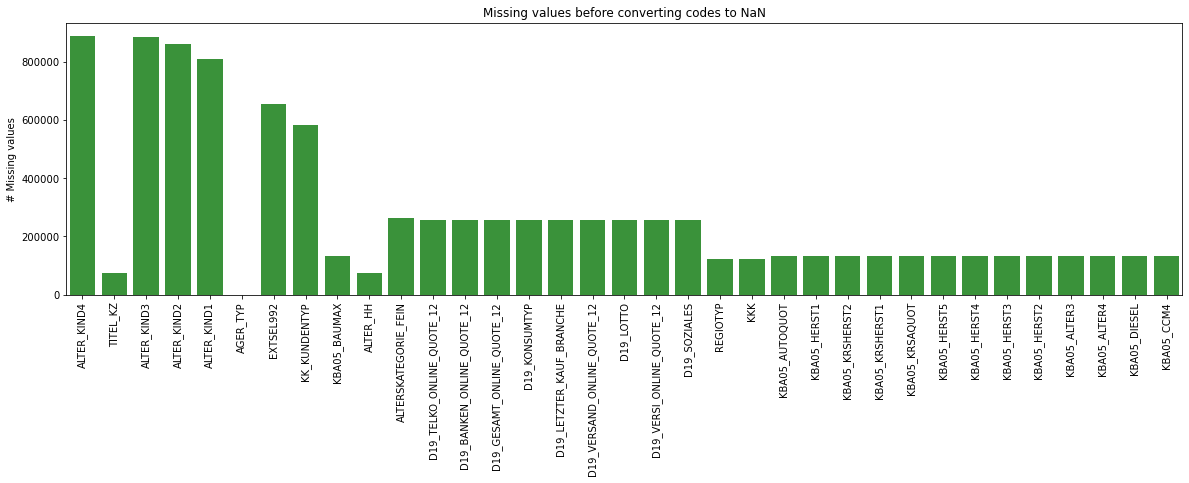

In [33]:
#attributes with maxi null values in original datasets
plot(df=azdias_null_comp, column='before')

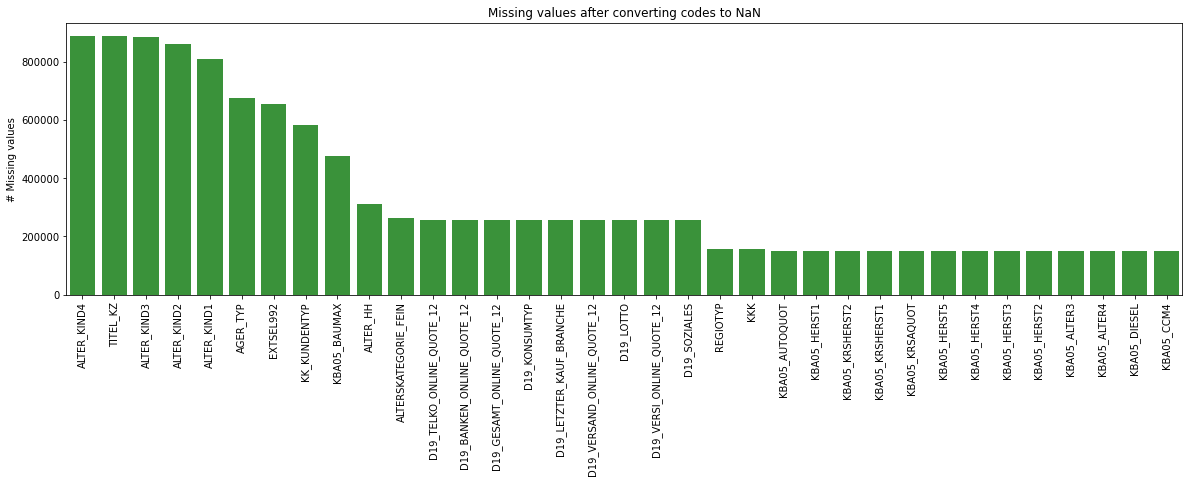

In [34]:
#attributes with top number of null values after converting codes to null values
plot(df=azdias_null_comp, column='after')

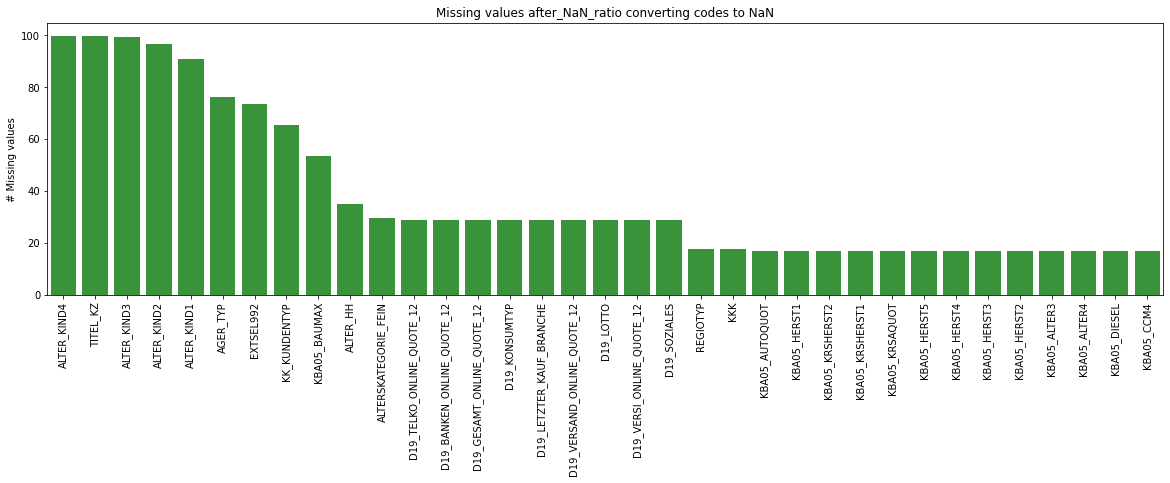

In [35]:
# percentage of null values for attributes with top number of null values after converting codes

plot(df=azdias_null_comp, column='after_NaN_ratio')

In [36]:
#summary of null value numbers and percentange before and after converting codes
azdias_null_comp.iloc[:,0:4].describe(percentiles=[0.2, 0.4, 0.50, 0.6, 0.7, 0.8, 0.946]).round(2)

,before,after,before_NaN_ratio,after_NaN_ratio
count,366.00,366.00,366.00,366.00
mean,91510.72,101333.03,10.27,11.37
std,108408.55,122440.97,12.16,13.74
min,0.00,0.00,0.00,0.00
20%,0.00,0.00,0.00,0.00
40%,97008.00,98979.00,10.88,11.11
50%,105800.00,105800.00,11.87,11.87
60%,105800.00,105800.00,11.87,11.87
70%,105800.00,105800.00,11.87,11.87
80%,133324.00,148110.00,14.96,16.62


array([[<AxesSubplot:title={'center':'NaN_ratio'}>]], dtype=object)

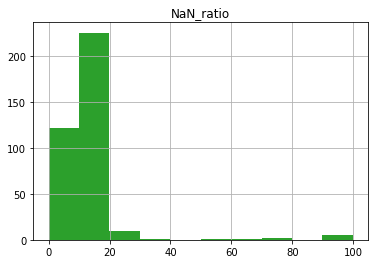

In [37]:
# Perform an assessment of how much missing data there is in each column of the dataset.

missing_eval = pd.DataFrame(data={'feature': azdias_null_comp.index, 'NaN_ratio': azdias_null_comp['after_NaN_ratio']})
missing_eval= missing_eval.sort_values(by='NaN_ratio', ascending=False)
# See the distribution in order to decide the criterion
missing_eval.hist(color = sns.color_palette()[2])

The missing ratio of most attributes are below 20%. Therefore, set criteria=20%.

#### 3.5 Drop columns with large amount of Nan values. Set criteria=20%

In [38]:
##remove columns with large amount of NA values
def re_na(data,crit=20):
    data_na = (data.isnull().sum()/len(data)*100).round(2)
    to_del = [i for i,v in enumerate(data_na) if v > crit]
    # drop useless columns
    data_remove_na = data.drop(data.columns[to_del], axis=1)
    print('Drop columns with large amount of Nan values.')
    cols_name = list(data_remove_na.columns)
    return data_remove_na,cols_name

In [39]:
#remove columns with large amount of NA values from azdias dataset
azdias_remove_na, col_list = re_na(azdias_cleaned1, crit=20)

Drop columns with large amount of Nan values.


Drop columns with accordingly based on azdia results:

In [40]:
customers_remove_na = customers_cleaned1[col_list]

In [41]:
print(azdias_remove_na.shape)
print(customers_remove_na.shape)

(891221, 346)
(191652, 346)


#### 3.6 Evaluate missing data in each row

Text(0, 0.5, 'number of rows')

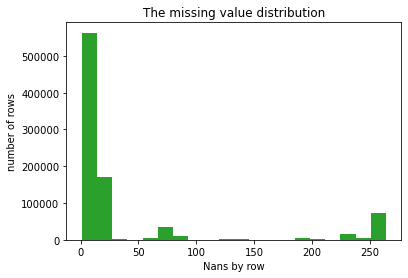

In [42]:
plt.figure()
plt.hist(len(azdias_cleaned1.columns) - azdias_cleaned1.count(axis=1), bins=20, color = sns.color_palette()[2])
plt.title('The missing value distribution')
plt.xlabel('Nans by row')
plt.ylabel('number of rows')

Based on the graph above, most rows have no missing value. All the rows with anu nan values will be dropped, and avoid any errors due to NaN values later on.

#### 3.7A Drop rows with Nan values

In [43]:
#drop any Na values from dataset
def drop_na(data):
    
    data_drop_na = data.dropna() 
    
    print('Drop rows with Nan values.')
    
    return data_drop_na


In [44]:
azdias_drop_na = drop_na(azdias_remove_na)

Drop rows with Nan values.


In [45]:
customers_drop_na = drop_na(customers_remove_na)

Drop rows with Nan values.


In [46]:
customers_remove_na.shape

(191652, 346)

In [47]:
print('{:.2%} of data is reserved in azdias dataset.'.format(azdias_drop_na.shape[0]/azdias.shape[0]))
print('{:.2%} of data is reserved in customers dataset.'.format(customers_drop_na.shape[0]/customers.shape[0]))

68.83% of data is reserved in azdias dataset.
60.01% of data is reserved in customers dataset.


#### 3.7B Impute data of Nan values with the most frequent values by row

In [48]:
def impute_na(df):
    '''
    Imputes the most frequent value per column.
    Input:
        df (dataframe) - dataframe to be used.
    Output:
        df_copy (dataframe) - imputed dataframe.
    '''

    cnter = 0
    bar = progressbar.ProgressBar(maxval = df.shape[1] + 1, 
                                  widgets = [progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    
    bar.start()

    for col in df.columns[df.isnull().any()]:
        cnter += 1
        bar.update(cnter)
        most_freq_value = df.groupby([col])[col].count().sort_values(ascending=False).index[0]
        df[col].fillna(most_freq_value, inplace=True)

    bar.finish()

    print('Impute Nan values with the most frequent values by row.')
    
    return df

#### 3.8 Evaluate the unique values of each column: remove columns with large set that introduce noises to datasets

In [49]:
#evaluate the numbers of unique values by column.
#drop the columns with large set of unqiue values that may bring noise to the dataset
azdias_drop_na.nunique().sort_values(ascending = False).head(20)

LNR                           613386
EINGEFUEGT_AM                   2469
KBA13_ANZAHL_PKW                1259
ANZ_HAUSHALTE_AKTIV              279
ANZ_STATISTISCHE_HAUSHALTE       252
GEBURTSJAHR                      116
VERDICHTUNGSRAUM                  46
CAMEO_DEU_2015                    44
CAMEO_INTL_2015                   42
LP_LEBENSPHASE_FEIN               41
EINGEZOGENAM_HH_JAHR              36
ANZ_PERSONEN                      24
MIN_GEBAEUDEJAHR                  21
ANZ_HH_TITEL                      19
CAMEO_DEUG_2015                   18
PRAEGENDE_JUGENDJAHRE             15
VK_DISTANZ                        13
LP_LEBENSPHASE_GROB               13
GFK_URLAUBERTYP                   12
LP_FAMILIE_FEIN                   11
dtype: int64

In [50]:
#drop the columns with large set of unqiue values that may bring noise to the dataset

def drop_unique_values(df,threholds = 50):      
    #get the index of features with number of unique values >50 which we drop those columns
    drop_unique_col = [col for col in df.columns if df[col].nunique() > threholds] 
       
    #drop the columns with large number of unique values
    df.drop(drop_unique_col, axis = 1,inplace=True)
    
    print('Drop columns with excessive large set of unique values.')

    return df,drop_unique_col
    

In [51]:
azdias_drop_uni,drop_unique_cols = drop_unique_values(azdias_drop_na,threholds = 50)

Drop columns with excessive large set of unique values.


In [52]:
drop_unique_cols

['LNR',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'EINGEFUEGT_AM',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW']

In [53]:
customers_drop_uni = customers_drop_na.drop(drop_unique_cols, axis = 1,inplace=True)

#### 3.9 Preparing dummy variable converting: identify String columns

In [54]:
###################################

In [55]:
#######################
######################
########################

##select string columns 
def str_columns(data):
    data_str = []
    for i in range(data.shape[1]):
        if(data.iloc[:,i].dtype == 'object'):
            data_str.append(data.iloc[:,i])
    
    df_str= pd.DataFrame(data_str)
    df_str = df_str.T
    str_li = list(df_str.columns)
    
    print('Return string column dataframe and column list.')
    
    return str_li

In [56]:
str_list = str_columns(azdias_drop_na) 

Return string column dataframe and column list.


In [57]:
str_list

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ']

In [58]:
azdias_drop_na[str_list].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ
1,8A,8.0,51.0,W
2,4C,4.0,24.0,W
4,6B,6.0,43.0,W
5,8C,8.0,54.0,W
6,4A,4.0,22.0,W


In [59]:
#check the set for object features
## prepare for dummy variable conversions

for i in range(len(str_list)):
        col_name = str_list[i]
        print('column name:{}'.format(col_name))
        print(set(azdias_drop_na[col_name].values))


column name:CAMEO_DEU_2015
{'4C', '1A', '7C', '6C', '6B', '1E', '5C', '5E', '4B', '6A', '8C', '9C', '2B', '9A', '3B', '9B', '9E', '7A', '6F', '8D', '7B', '2D', '3D', '5F', '1C', '5B', '8A', '2A', '6D', '2C', '5D', '4A', '9D', '4E', '7E', '6E', '3C', '5A', '7D', '1D', '8B', '4D', '3A', '1B'}
column name:CAMEO_DEUG_2015
{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, '3', '5', '6', '8', '4', '2', '1', '7', '9'}
column name:CAMEO_INTL_2015
{'44', '22', 12.0, 13.0, 14.0, 15.0, '32', 22.0, 23.0, 24.0, 25.0, '12', 31.0, 32.0, 33.0, 34.0, 35.0, '15', 41.0, 43.0, 44.0, 45.0, '33', 51.0, 52.0, '45', 54.0, 55.0, '23', '55', '25', '24', '34', '41', '43', '35', '14', '52', '54', '13', '31', '51'}
column name:OST_WEST_KZ
{'W', 'O'}


#### 3.10 Preparing dummy variable converting: format string columns with unique values

In [60]:
def str_process(df, str_li):
    #convert mix column 'CAMEO_DEUG_2015','CAMEO_INTL_2015' to int type, and convert back to string
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(int).astype(str)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(int).astype(str)
    
    return df

In [61]:
azdias_drop_na_str = str_process(azdias_drop_na,str_list)

In [62]:
customers_drop_na_str = str_process(customers_drop_na,str_list)

In [63]:
customers_drop_na.shape

(115017, 340)

#### 3.11 Prepare calculating correlation among columns: identify numeric columns

In [64]:
### check the correlation
### removes columns with high correlations with other columns

In [65]:
##select numeric columns 
def numeric_columns(data):
    data_numeric = []
    for i in range(data.shape[1]):
        if(data.iloc[:,i].dtype == 'float64' or data.iloc[:,i].dtype == 'int64'):
            data_numeric.append(data.iloc[:,i])
    
    d_numeric_f = pd.DataFrame(data_numeric)
    d_numeric_f = d_numeric_f.T
    
    d_numeric_li = list(d_numeric_f.columns)
    
    print('Return numerical columns dataframe.')
    
    return d_numeric_f,d_numeric_li

In [66]:
d_numeric,d_numeric_list = numeric_columns(azdias_drop_na) 

Return numerical columns dataframe.


In [67]:
d_numeric_list

['AKT_DAT_KL',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_TECHNIK',
 'D19_TELKO_A

In [68]:
# The correlation matrix
corr_mat = d_numeric.corr()

<AxesSubplot:>

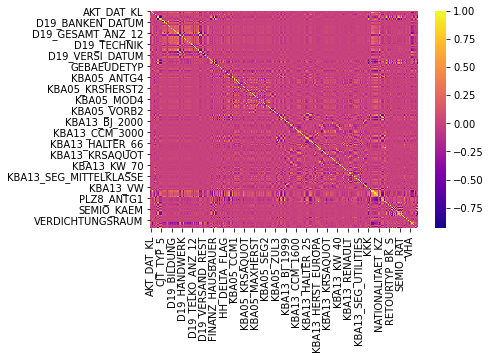

In [69]:
plt.figure()
sns.heatmap(corr_mat, cmap='plasma')

#### 3.12 Retain the features with absolute values of correlations fewer than 0.4

In [70]:
#drop columns with correlation coff >0.4
def drop_high_corr(df,d_numeric,d_numeric_li):
    
    corr_mat = d_numeric.corr()
    cor_abs = corr_mat.abs()
    #to consider only the upper triangle of the matrix
    #as the upper and lower triangles are the same
    upper_mx = cor_abs.where(np.triu(np.ones(cor_abs.shape),k=1).astype(np.bool))

    #get the index of features with correlation coff less than 0.4 which we will retain
    drop_vars_cor = [col for col in upper_mx.columns if any(upper_mx[col] > 0.4)]
    
    #drop the columns with high correlations
    df.drop(drop_vars_cor, axis = 1,inplace=True)

    
    print('Drop columns with high correlation coffeiency with others.')
    
    return df,drop_vars_cor


In [71]:
azdias_drop_corr,drop_corr_list = drop_high_corr(azdias_drop_na, d_numeric, d_numeric_list)

Drop columns with high correlation coffeiency with others.


drop columns for customers dataset accordingly based on azdias result:

In [72]:
customers_drop_na.drop(drop_corr_list,axis = 1,inplace=True)

In [73]:
azdias_drop_na.shape

(613386, 111)

Notice:

CAMEO_DEUG_2015,CAMEO_INTL_2015 have mix types, and have been converted to int.

OST_WEST_KZ only has two values: O,W



#### 3.13 Converting categorical variables to dummy variables

In [74]:
def categorical_dict(cols_dict, col2, target_df):
    ###get attributes from feature_summary file that are categorical data
    cat_dict=set(cols_dict[cols_dict['Type']== 'categorical'].Attribute.values)
    ### get column list from dataset
    cols_list = set(target_df.columns.values)
    
    cat_list = list(cols_list.intersection(cat_dict))
    ### add columns identified by str_columns function according to columns' dtype in the dataframe 
    cat_list.extend(col2)
    
    li= list(set(cat_list))
    
    d_dummy_d = pd.get_dummies(target_df, columns = li)
    
    print('Convert categorical columns to dummy variables.')
  
    return li, d_dummy_d


In [75]:
c_list,azdias_d_dummy = categorical_dict(feature_summary, str_list, azdias_drop_na)

Convert categorical columns to dummy variables.


In [76]:
c_list

['CJT_GESAMTTYP',
 'CAMEO_DEUG_2015',
 'NATIONALITAET_KZ',
 'VERS_TYP',
 'CAMEO_INTL_2015',
 'GEBAEUDETYP',
 'CAMEO_DEU_2015',
 'OST_WEST_KZ',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'KBA05_HERSTTEMP']

transform dummy variables accordingly based on azdias dataset:

In [77]:
customers_d_dummy = pd.get_dummies(customers_drop_na, columns = c_list)

In [78]:
print(azdias_d_dummy.shape)
print(customers_d_dummy.shape)

(613386, 215)
(115017, 214)


One dummy variable is missing in customers dataset comparing to azdias.

#### 3.14 Evaluate values of categorical columsn between customer and azdias dataset and find out the missing dummy variable value.

In [79]:
###print out full list of categorical columns that for dummy variables
for i in range(len(c_list)):
        col_name = c_list[i]
        print('column name:{}'.format(col_name))
        print(set(azdias_drop_na[col_name]))

column name:CJT_GESAMTTYP
{1.0, 2.0, 3.0, 4.0, 5.0, 6.0}
column name:CAMEO_DEUG_2015
{'3', '5', '6', '8', '4', '2', '1', '7', '9'}
column name:NATIONALITAET_KZ
{1.0, 2.0, 3.0}
column name:VERS_TYP
{1.0, 2.0}
column name:CAMEO_INTL_2015
{'44', '22', '32', '12', '15', '33', '45', '23', '55', '25', '24', '34', '41', '43', '35', '14', '52', '54', '13', '31', '51'}
column name:GEBAEUDETYP
{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0}
column name:CAMEO_DEU_2015
{'4C', '1A', '7C', '6C', '6B', '1E', '5C', '5E', '4B', '6A', '8C', '9C', '2B', '9A', '3B', '9B', '9E', '7A', '6F', '8D', '7B', '2D', '3D', '5F', '1C', '5B', '8A', '2A', '6D', '2C', '5D', '4A', '9D', '4E', '7E', '6E', '3C', '5A', '7D', '1D', '8B', '4D', '3A', '1B'}
column name:OST_WEST_KZ
{'W', 'O'}
column name:GFK_URLAUBERTYP
{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0}
column name:GREEN_AVANTGARDE
{0, 1}
column name:HEALTH_TYP
{1.0, 2.0, 3.0}
column name:KBA05_HERSTTEMP
{1.0, 2.0, 3.0, 4.0, 5.0}


In [80]:
###print out full list of categorical columns that for dummy variables
for i in range(len(c_list)):
        col_name = c_list[i]
        print('column name:{}'.format(col_name))
        print(set(customers_drop_na[col_name]))

column name:CJT_GESAMTTYP
{1.0, 2.0, 3.0, 4.0, 5.0, 6.0}
column name:CAMEO_DEUG_2015
{'3', '5', '6', '8', '4', '2', '1', '7', '9'}
column name:NATIONALITAET_KZ
{1.0, 2.0, 3.0}
column name:VERS_TYP
{1.0, 2.0}
column name:CAMEO_INTL_2015
{'44', '22', '32', '12', '15', '33', '45', '23', '55', '25', '24', '34', '41', '43', '35', '14', '52', '54', '13', '31', '51'}
column name:GEBAEUDETYP
{1.0, 2.0, 3.0, 4.0, 6.0, 8.0}
column name:CAMEO_DEU_2015
{'4C', '1A', '7C', '6C', '6B', '1E', '5C', '5E', '4B', '6A', '9C', '8C', '2B', '9A', '3B', '9B', '9E', '7A', '6F', '8D', '7B', '2D', '3D', '5F', '1C', '5B', '8A', '2A', '6D', '2C', '5D', '4A', '9D', '4E', '7E', '6E', '3C', '5A', '1D', '7D', '8B', '3A', '4D', '1B'}
column name:OST_WEST_KZ
{'W', 'O'}
column name:GFK_URLAUBERTYP
{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0}
column name:GREEN_AVANTGARDE
{0, 1}
column name:HEALTH_TYP
{1.0, 2.0, 3.0}
column name:KBA05_HERSTTEMP
{1.0, 2.0, 3.0, 4.0, 5.0}


#### 3.15 compare azdias and customers dummy variables,GEBAEUDETYP have none value of '5.0'. 
#### add customers_d_dummy['GEBAEUDETYP_5.0'] to the dataset with value 0.
#### azdias_d_dummy,customers_d_dummy have consistant dataframes.

In [81]:
customers_d_dummy['GEBAEUDETYP_5.0']=0

In [82]:
print(azdias_d_dummy.shape)
print(customers_d_dummy.shape)

(613386, 215)
(115017, 215)


In [83]:
def clean_data(data,df_common_dict = df_common_dict, col_list = col_list, drop_unique_cols = drop_unique_cols, str_list = str_list, drop_corr_list = drop_corr_list, c_list=c_list):
    data_cleaned1 = data.copy()
    data_cleaned1 = convert_missing_to_nan(data,df_common_dict)
    data_cleaned1.replace('X',np.nan,inplace=True) 
    data_cleaned1.replace('XX',np.nan,inplace=True) 
    data_remove_na = data_cleaned1[col_list]
    data_drop_na = drop_na(data_remove_na)
    print('{:.2%} of data is reserved after removing null values.'.format(data_drop_na.shape[0]/data.shape[0]))
    data_drop_na.drop(drop_unique_cols, axis = 1,inplace=True)
    str_process(data_drop_na,str_list)
    data_drop_na.drop(drop_corr_list,axis = 1,inplace=True)
    data_d_dummy = pd.get_dummies(data_drop_na, columns = c_list)
    return data_drop_na,data_d_dummy

In [84]:
#########alternatives for test dataset:impute Nan value of the data insdead of dropping nans

In [85]:
def clean_data_test(data,df_common_dict = df_common_dict, col_list = col_list, drop_unique_cols = drop_unique_cols, str_list = str_list, drop_corr_list = drop_corr_list, c_list=c_list):
    data_cleaned1 = data.copy()
    data_cleaned1 = convert_missing_to_nan(data,df_common_dict)
    data_cleaned1.replace('X',np.nan,inplace=True) 
    data_cleaned1.replace('XX',np.nan,inplace=True) 
    data_remove_na = data_cleaned1[col_list]
    data_impute_na = impute_na(data_remove_na)
    data_impute_na.drop(drop_unique_cols, axis = 1,inplace=True)
    str_process(data_impute_na,str_list)
    data_impute_na.drop(drop_corr_list,axis = 1,inplace=True)
    data_d_dummy = pd.get_dummies(data_impute_na, columns = c_list)
    return data_impute_na,data_d_dummy


### 4. Evaluate categorical column values between customer and azdias datasets.

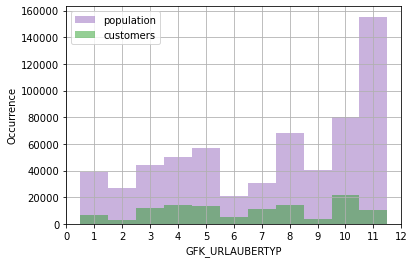

In [89]:
####build categorical dataframe with population and customer datasets
azdias_cat = azdias_drop_na.loc[:,c_list]
customers_cat = customers_drop_na.loc[:,c_list]

azdias_cat['Group']='population'
customers_cat['Group']='customers'

cat_df = pd.concat([azdias_cat, customers_cat], ignore_index=True)

###########


#customer colors
green = sns.color_palette()[2]
purple = sns.color_palette()[4]

#set bins for histgram
bin_range = np.array(range(0,13))

#plot histgram of GFK_URLAUBERTYP counts for multiple and single buyers
ax = plt.axes()
for customer_group, plot_color in zip (['population','customers'],[purple,green]):
    c_data= cat_df.loc[cat_df.Group==customer_group, 'GFK_URLAUBERTYP']
    c_data.hist(bins=bin_range,alpha=0.5, ax=ax, color = plot_color, label= customer_group)
        
ax.legend()
ax.set(xlabel = 'GFK_URLAUBERTYP',  ylabel='Occurrence')

# force tick labels to be in the middle
ax.set_xlim(3,10)
ax.set_xticks(bin_range+0.5)
ax.set_xticklabels(bin_range);
ax.grid('off')
                                    

### 5. Finally, visualise the pairplot of the transformed features.

In [86]:
azdias_df = azdias_d_dummy.copy()
customers_df = customers_d_dummy.copy()
azdias_df['Group'] = 'population'
customers_df['Group'] = 'customer'

union_df = pd.concat([azdias_df,customers_df],ignore_index=True)

numeric_columns = [x for x in customers_d_dummy.columns if x not in ['Group']]

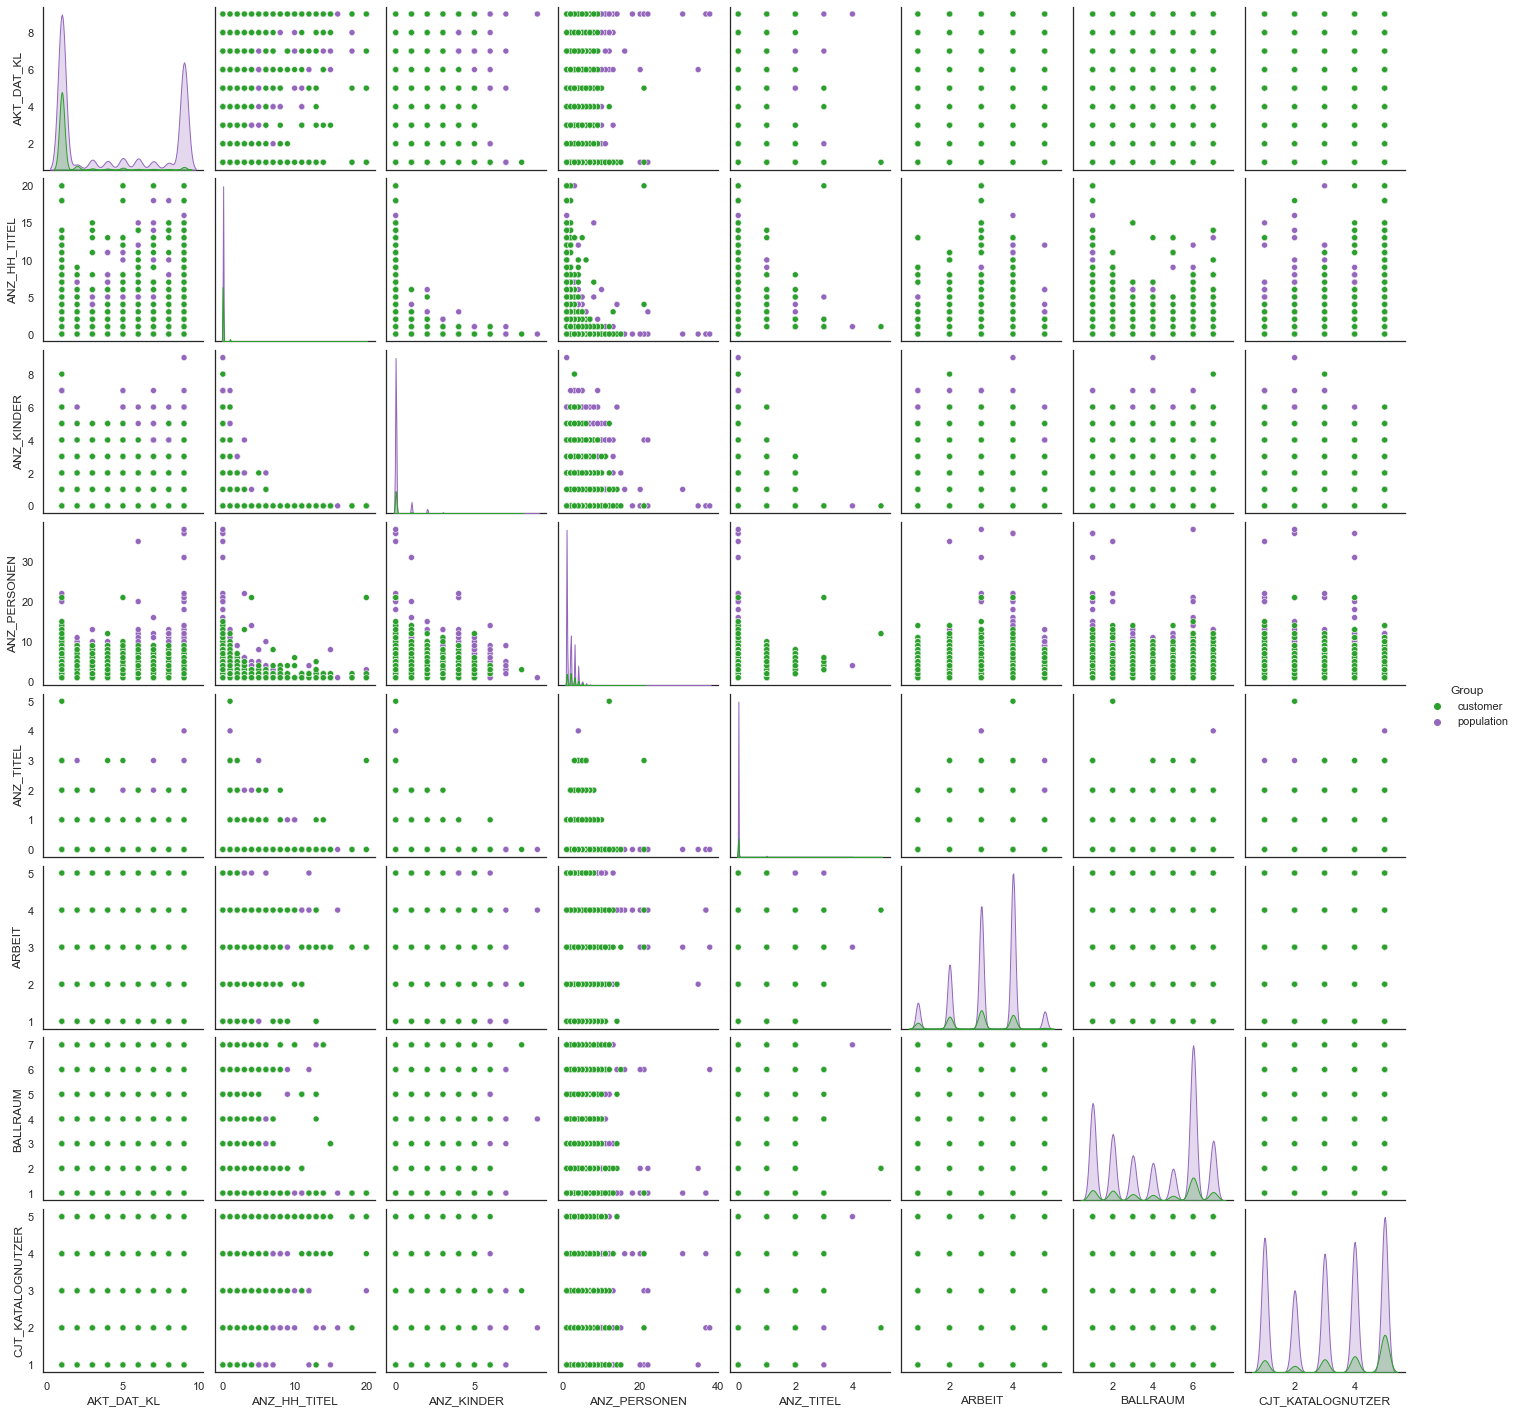

In [91]:
#Finally, visualise the pairplot of the transformed and scaled features.
sns.set_context('notebook')
sns.set_style('white')

#customer colors
green = sns.color_palette()[2]
purple = sns.color_palette()[4]

sns.pairplot(union_df[numeric_columns[:8]+ ['Group']], 
             hue='Group', 
             hue_order=['customer','population'],
             palette={'customer':green, 'population':purple});

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.


### 1. Feature Scaling

In [87]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
customers_Scaler = sc.fit_transform(customers_d_dummy)
azdias_Scaler = sc.fit_transform(azdias_d_dummy)


### 2. Feature Transformation

#### 2.1 Perform Dimension Reduction: PCA implementation

This sector uses principal component analysis (PCA) to draw conclusions about the underlying structure of the population data. 

Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers(customer segments).


- Import sklearn.decomposition.PCA and assign the results of fitting PCA in 215 dimensions with population dataset(azdias_d_dummy).
- Apply the PCA transformation above to the customers dataset(customers_d_dummy) using pca.transform.

In [88]:
# TODO: Apply PCA by fitting the azdias data with the same number of dimensions as features
from sklearn.decomposition import PCA

# Instantiate
pca = PCA(n_components=215)

# Fit
pca.fit(azdias_Scaler)

# Investigate the variance accounted for by each principal component.
variance = pca.explained_variance_ratio_
cumsum_variance=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)


# TODO: Transform the customer dataset using the PCA fit above
pca_customers = pca.transform(customers_Scaler)
#print("Explained Variance Ratio => {}\n".format(variance))
#print("Explained Variance Ratio(csum) => {}\n".format(cumsum_variance))




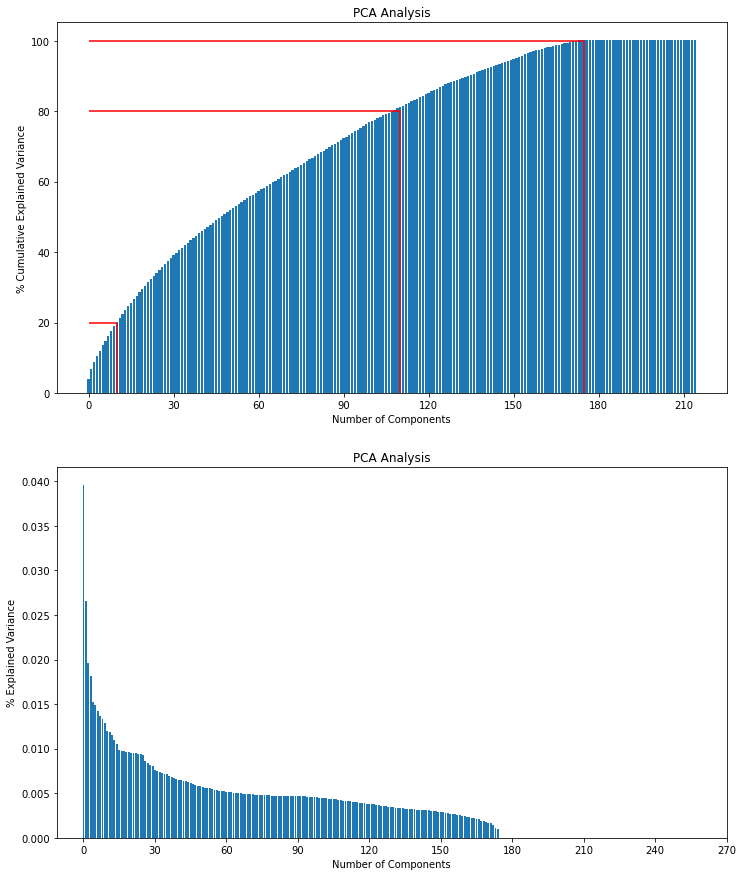

In [89]:
# Generate PCA results plot
n_components = len(pca.explained_variance_ratio_)
index = np.arange(n_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(12,15))
plt.subplot(2, 1, 1)
plt.bar(index, cumsum_variance)
plt.ylabel('% Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.xticks(np.linspace(0,300, 10, endpoint=False))
plt.title('PCA Analysis')

# 15 components
plt.hlines(y=20, xmin=0, xmax=10, color='red', linestyles='-',zorder=1)
plt.vlines(x=10, ymin=0, ymax=20, color='red', linestyles='-',zorder=2)

# 100 components
plt.hlines(y=80, xmin=0, xmax=110, color='red', linestyles='-',zorder=3)
plt.vlines(x=110, ymin=0, ymax=80, color='red', linestyles='-',zorder=4)

# 200
plt.hlines(y=100, xmin=0, xmax=175, color='red', linestyles='-',zorder=5)
plt.vlines(x=175, ymin=0, ymax=100, color='red', linestyles='-',zorder=6)

plt.subplot(2, 1, 2)
plt.bar(index, vals)
plt.xticks(np.linspace(0,300, 10, endpoint=False))
plt.xlabel('Number of Components')
plt.ylabel('% Explained Variance')
plt.title('PCA Analysis');

#### 2.2 Reduce dimension:
Re-fit with n components achieving 0.95 variance

In [90]:
from sklearn.decomposition import PCA
# Reduce dimension: re-fit with n components explain 0.85 variance
# apply PCA
pca = PCA(0.95)
# fit transform
pca_out = pca.fit(azdias_Scaler)

In [91]:
loadings = pca_out.n_components_
print('Numbers of components achieves 95% variances:{}'.format(loadings))
azdias_pca_scores = pca.transform(azdias_Scaler)
customers_pca_scores = pca.transform(customers_Scaler)

Numbers of components achieves 95% variances:152


In [92]:
azdias_pca_scores=pd.DataFrame(azdias_pca_scores)
customers_pca_scores=pd.DataFrame(customers_pca_scores)

In [93]:
np.cumsum(pca.explained_variance_ratio_[:20])

array([0.03959487, 0.06613273, 0.08573939, 0.10391575, 0.11915776,
       0.13400526, 0.14821172, 0.16184629, 0.17513373, 0.18799654,
       0.20003178, 0.21190227, 0.22342616, 0.23438273, 0.24485101,
       0.25468374, 0.26447267, 0.27421718, 0.28386805, 0.29345689])

In [94]:
azdias_pca_scores_df = pd.DataFrame({'var':pca.explained_variance_ratio_[:20],
             'PC':list(azdias_pca_scores.columns.values)[:20]})

<AxesSubplot:xlabel='PC', ylabel='var'>

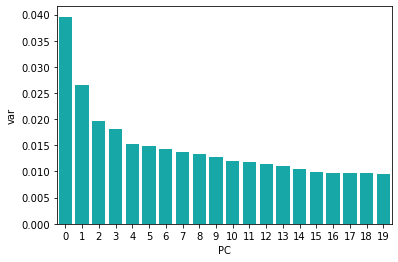

In [95]:
sns.barplot(x='PC',y="var", data=azdias_pca_scores_df, color="c")

#### 2.3 Scatter Plot analysis of Primary Component 1 and 2

Text(0, 0.5, 'Second Principal Component')

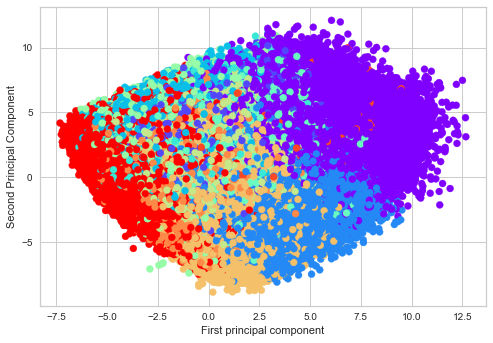

In [107]:
# Scatter Plot of component 1 and component 2

plt.scatter(azdias_pca_scores.iloc[:,0], azdias_pca_scores.iloc[:,1],c=azdias_preds,cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')


#### 2.3 3D Scatter Plot analysis of Primary Component 1, 2 and 3

In [ ]:
import plotly.express as px
df=azdias_pca_scores.iloc[:300,0:3]
df.columns =['Component1','Component2','Component3']
df['Cluster'] = azdias_preds[:300].astype(str)

fig = px.scatter_3d(
    df,
    x='Component1', 
    y='Component2', 
    z='Component3',
    color = 'Cluster',
    color_discrete_sequence = px.colors.qualitative.Pastel,
    title='3D Principle Components Scatter Plot',
    opacity=0.7
   
    )

fig.show()

#### 2.4 effect analysis of variables on each components

components_ attribute provides axes in feature space, representing the directions of maximum variance in the data. 

Check the effect of variables on top25 components:

[Text(0.5, 207.7720000000001, 'Attributes'),
 Text(124.0, 0.5, 'Components'),
 Text(0.5, 1.0, 'Effect of variables on each components')]

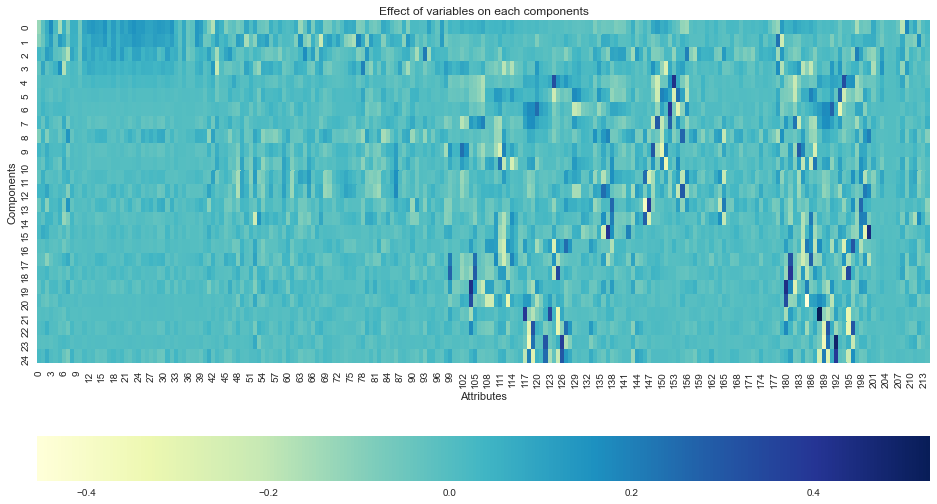

In [109]:
#check the effect of variables on top25 components
plt.figure(figsize=(16,9))
ax = sns.heatmap(pca.components_[:25,:],
                 cmap='YlGnBu',         
                 #yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 #xticklabels=list(azdias_d_dummy.columns),
                 cbar_kws={"orientation": "horizontal"})

ax.set(xlabel='Attributes', 
       ylabel='Components',
       title='Effect of variables on each components')


Check the effect of variables on the top5 componenets:

Text(0, 0.5, 'Factor loading onto PC5')

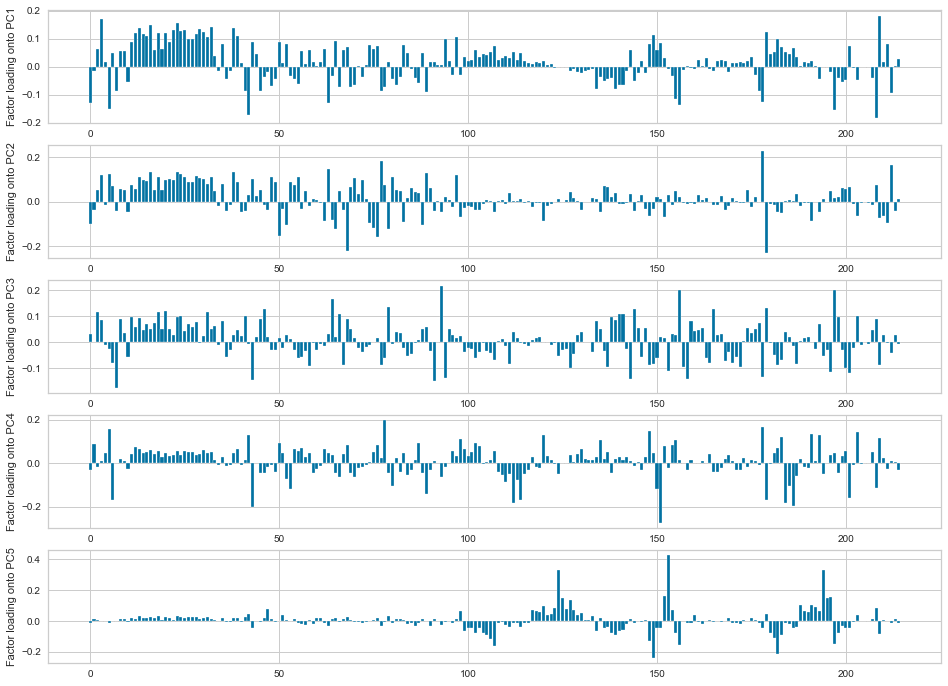

In [110]:
fig, ax = plt.subplots(5, 1,figsize=(16, 12))

xlabels = list(azdias_d_dummy.columns)

ax[0].bar(range(len(xlabels)), pca.components_[0, :], align='center')
ax[1].bar(range(len(xlabels)), pca.components_[1, :], align='center')
ax[2].bar(range(len(xlabels)), pca.components_[2, :], align='center')
ax[3].bar(range(len(xlabels)), pca.components_[3, :], align='center')
ax[4].bar(range(len(xlabels)), pca.components_[4, :], align='center')

ax[0].set_ylabel('Factor loading onto PC1')
ax[1].set_ylabel('Factor loading onto PC2')
ax[2].set_ylabel('Factor loading onto PC3')
ax[3].set_ylabel('Factor loading onto PC4')
ax[4].set_ylabel('Factor loading onto PC5')




In [137]:
#return the index of columns where the effect of attributes upon componets are >0.4
sig_li = list(np.where(pca.components_>0.5)[1])
azdias_d_dummy.columns.values[sig_li]

array(['CAMEO_INTL_2015_31', 'KBA05_HERSTTEMP_1.0', 'KBA05_HERSTTEMP_4.0',
       'D19_TELKO_ONLINE_DATUM', 'CAMEO_DEU_2015_7E', 'GEBAEUDETYP_4.0',
       'GEBAEUDETYP_5.0', 'SOHO_KZ', 'D19_DIGIT_SERV', 'D19_BANKEN_REST',
       'D19_HANDWERK', 'D19_BUCH_CD'], dtype=object)

In [136]:
np.where(pca.components_>0.5)

(array([ 21,  46,  50,  69,  76,  89,  90,  91, 108, 116, 127, 149]),
 array([199, 143, 146,  34, 133, 187, 188,  92,  17,  11,  22,  16]))

#### 2.5 PCA component analysis and visualisation

In [115]:
def interpret_pca(df, pca, component):
    '''
    Maps each weight to its corresponding feature name and sorts according to weight.
    Args:
        df (dataframe): dataframe on which pca has been used on.
        pca (pca): pca object.
        component (int): which principal compenent to return
    Returns:
        df_pca (dataframe): dataframe for specified component containing the explained variance
                            and all features and weights sorted according to weight.
    '''
    df_pca = pd.DataFrame(columns=list(df.columns))
    df_pca.loc[0] = pca.components_[component]
    dim_index = "Dimension: {}".format(component + 1)

    df_pca.index = [dim_index]
    df_pca = df_pca.loc[:, df_pca.max().sort_values(ascending=False).index]

    ratio = np.round(pca.explained_variance_ratio_[component], 4)
    df_pca['Explained Variance'] = ratio

    cols = list(df_pca.columns)
    cols = cols[-1:] + cols[:-1]
    df_pca = df_pca[cols]

    return df_pca

In [116]:
dim1 = interpret_pca(azdias_d_dummy,pca,0)

In [117]:
dim1

,Explained Variance,GREEN_AVANTGARDE_1,ANZ_PERSONEN,D19_HAUS_DEKO,D19_BUCH_CD,D19_TECHNIK,D19_BEKLEIDUNG_REST,D19_VOLLSORTIMENT,D19_REISEN,D19_HANDWERK,...,KBA05_HERSTTEMP_3.0,CAMEO_DEUG_2015_8,OST_WEST_KZ_O,AKT_DAT_KL,KBA13_ALTERHALTER_30,CAMEO_DEUG_2015_9,ARBEIT,CAMEO_INTL_2015_51,FINANZ_HAUSBAUER,GREEN_AVANTGARDE_0
Dimension: 1,0.0396,0.182181,0.170355,0.155327,0.148832,0.142447,0.136481,0.136309,0.13305,0.132013,...,-0.092364,-0.116611,-0.124037,-0.12877,-0.130315,-0.135248,-0.149986,-0.154412,-0.171215,-0.182181


In [118]:
def plot_pca(dim, num):
    '''
    Plots the "top" and "bottom" 4 features and weights.
    Args:
        dim (row) - dimension from pca dataframe.
        num (int) - which dimension/compenent.
    '''
    features = dim.iloc[:, np.r_[1:10, -9, -8, -7, -6, -5, -4, -3, -2, -1]]
    feature_names = features.columns
    weights = features.iloc[0].values

    sns.set(style='whitegrid')
    sns.set_color_codes('pastel')
    fig = plt.figure(figsize=(10, 5))
    sns.set()

    ax = sns.barplot(x=weights, y=feature_names)
    ax.set(xlabel="Weight", ylabel="Feature", title=f'Component {num}')


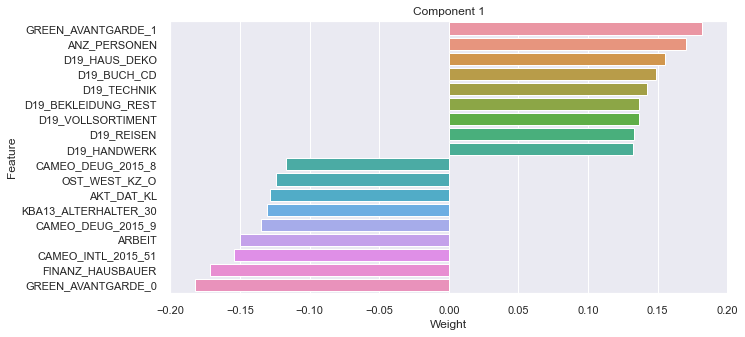

In [119]:
plot_pca(dim1, 1)

#### 2.6 PCA Biplot analysis

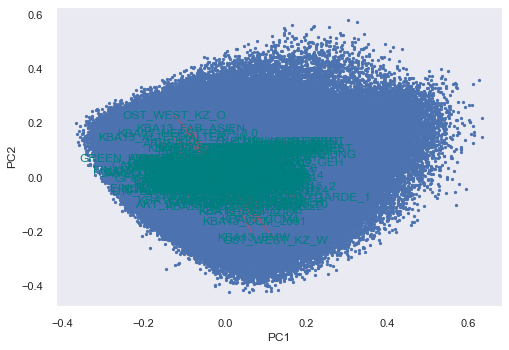

In [120]:
###biplot: Primary component1 & component2

def myplot(score, coeff, labels = None):
    xs = score.loc[:,0]
    ys = score.loc[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1/(ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley, s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i,0]*1.15,
                     coeff[i,1]*1.15,
                     "Var"+str(i+1), 
                     color = 'teal', 
                     ha = 'center', 
                     va = 'center')
        else:
            plt.text(coeff[i,0]* 1, 
                     coeff[i,1] * 1, 
                     labels[i], color = 'teal', 
                     ha = 'center', 
                     va = 'center')
        plt.xlabel("PC{}".format(1))
        plt.ylabel("PC{}".format(2))
        plt.grid()
        
        
myplot(azdias_pca_scores.loc[:,0:2],np.transpose(pca.components_[0:2, :]),list(azdias_d_dummy.columns))
plt.show()

In [121]:
###biplot function 
def myplot(score, coeff, labels = None):
    xs = score.loc[:,0]
    ys = score.loc[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1/(ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley, s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color='r', alpha=0.5)
        
        plt.xlabel("PC{}".format(1))
        plt.ylabel("PC{}".format(2))
        plt.grid()
  

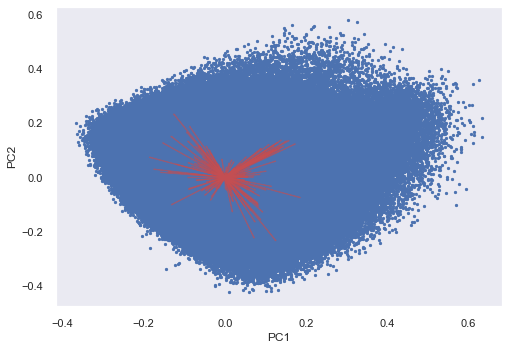

In [122]:
myplot(azdias_pca_scores.loc[:,0:2],np.transpose(pca.components_[0:2, :]),labels = None)
plt.show()

#### 2.7 Find optimize cluster numbers

#### Solution 1

The number of clusters is unknown. To find out the optimize number of clusters, we can:  

* Now fit K-Means models with cluster values ranging from 1 to 20.
* For each model, store the number of clusters and the inertia value. 
* Plot cluster number vs inertia. find out an ideal cluster number?

In [123]:
from sklearn.cluster import KMeans
# Create and fit a range of models

km_list = list()

cnter = 0
bar = progressbar.ProgressBar(maxval=50+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

for clust in range(1,50):
    cnter+=1 
    bar.update(cnter)
    
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(azdias_pca_scores)
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))
        
    
bar.finish()

[========================================================================] 100%


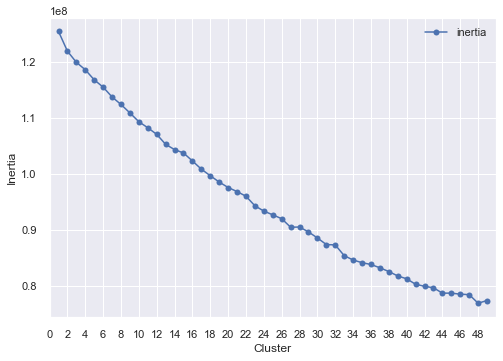

In [124]:
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,50,2))
ax.set_xlim(0,50)
ax.set(xlabel='Cluster', ylabel='Inertia');
### END SOLUTION

Here, unfortunately we cannot see a very distinct elbow point. 

#### Solution 2

In [96]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

Note,choose calinski harabasz score while comparing the differntmetrics.
- distortion: mean sum of squared distances to centers.
- silhouette: mean ratio of intra-cluster and nearest-cluster distance.
- calinski harabasz: ratio of within to between cluster dispersion.

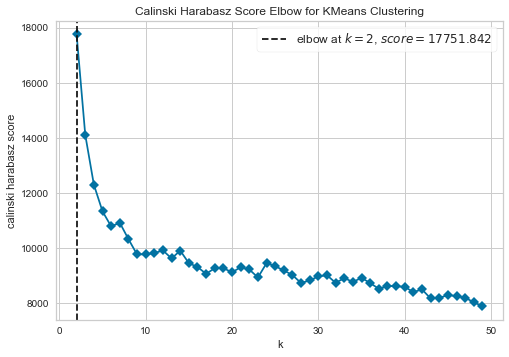

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [98]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='calinski_harabasz', timings=False
)

visualizer.fit(azdias_pca_scores)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


Result: Elbow at k = 12.

#### 2.8 Cluster Visualization(with optimise number k=12)

* Use the chosed optimal number of clusters with the scoring metric above. 
* visualize the results.

In [78]:
# refoerm PCA with optimised number of clusters
clusterer = KMeans(n_clusters=12, random_state=42).fit(azdias_pca_scores)
azdias_preds = clusterer.predict(azdias_pca_scores)
centers = clusterer.cluster_centers_
customers_preds = clusterer.predict(customers_pca_scores)



Text(0.5, 1.0, 'Customers Dataset')

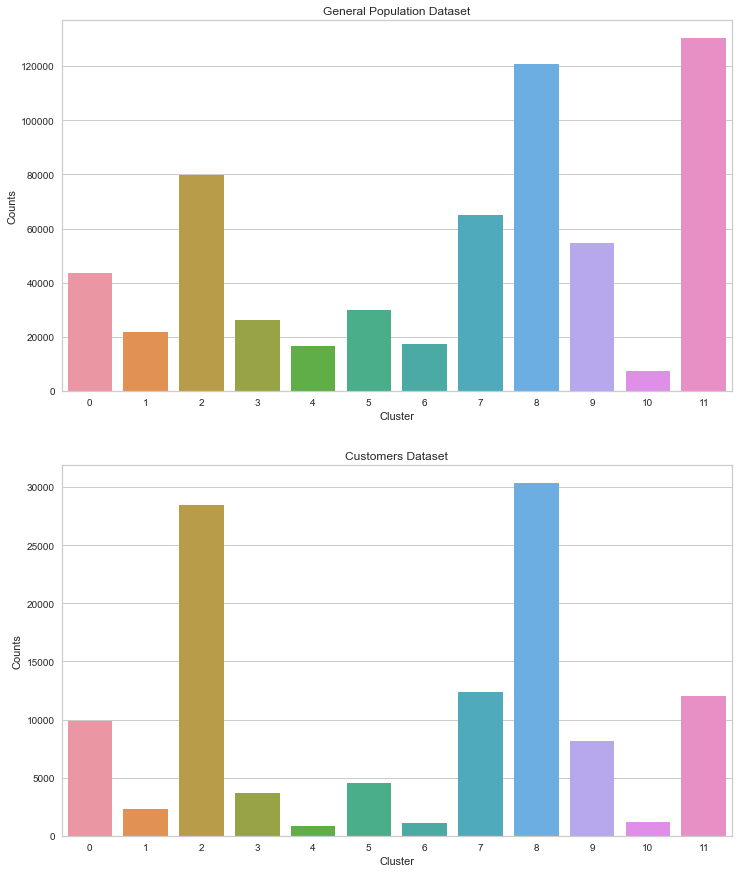

In [79]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

plt.figure(figsize=(12,15))
plt.subplot(2, 1, 1)
sns.countplot(azdias_preds)
plt.xlabel('Cluster')
plt.ylabel('Counts')
plt.title('General Population Dataset')

plt.subplot(2, 1, 2)
sns.countplot(customers_preds)
plt.xlabel('Cluster')
plt.ylabel('Counts')
plt.title('Customers Dataset')

#### Top clusters of customer dataset are:
- Cluster 8
- Cluster 2

#### Clusters that are unlikely to be customers:
- Cluster 6


Future explore the typical characterics of these clusters. 

#### 2.9 Components Reverse Analysis

Each cluster presents in the visualisation above has a central point. These centers(means) are not specifically data points from the data, but rather the averages of all the data points predicted in the respective clusters.

For the problem of creating customer segments, a cluster's center point corresponds to the average customer of that segment.

The representative customer can be recovered by applying the reverse tranformation.

In [90]:
### Inverse tranform the centers
azdias_centers = pca.inverse_transform(centers)


In [91]:
#reverse the scaler
true_azdias_centers = sc.inverse_transform(azdias_centers)

In [92]:
# Display the true centers as the representative of segments
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_azdias_centers = pd.DataFrame(np.round(true_azdias_centers), columns = azdias_d_dummy.columns)
true_azdias_centers.index = segments
####segment center
display(true_azdias_centers)

,AKT_DAT_KL,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,D19_BANKEN_ANZ_12,D19_BANKEN_LOKAL,...,CAMEO_INTL_2015_43,CAMEO_INTL_2015_44,CAMEO_INTL_2015_45,CAMEO_INTL_2015_51,CAMEO_INTL_2015_52,CAMEO_INTL_2015_54,CAMEO_INTL_2015_55,HEALTH_TYP_1.0,HEALTH_TYP_2.0,HEALTH_TYP_3.0
Segment 0,2.0,0.0,0.0,3.0,0.0,3.0,5.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 1,4.0,0.0,0.0,2.0,0.0,4.0,4.0,4.0,0.0,0.0,...,0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
Segment 2,4.0,0.0,0.0,2.0,0.0,3.0,4.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 3,5.0,0.0,0.0,2.0,0.0,4.0,4.0,3.0,0.0,0.0,...,0.0,0.0,-0.0,0.0,-0.0,1.0,0.0,0.0,0.0,0.0
Segment 4,5.0,0.0,0.0,2.0,0.0,4.0,4.0,3.0,0.0,0.0,...,0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,0.0,0.0,0.0
Segment 5,4.0,0.0,0.0,2.0,0.0,3.0,5.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Segment 6,4.0,0.0,0.0,2.0,0.0,4.0,4.0,4.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1.0,0.0,0.0,0.0
Segment 7,5.0,0.0,0.0,2.0,0.0,3.0,4.0,3.0,0.0,0.0,...,1.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0
Segment 8,4.0,0.0,0.0,2.0,0.0,3.0,5.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
Segment 9,5.0,0.0,0.0,2.0,0.0,3.0,4.0,3.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='Segment 6', ylabel='count'>

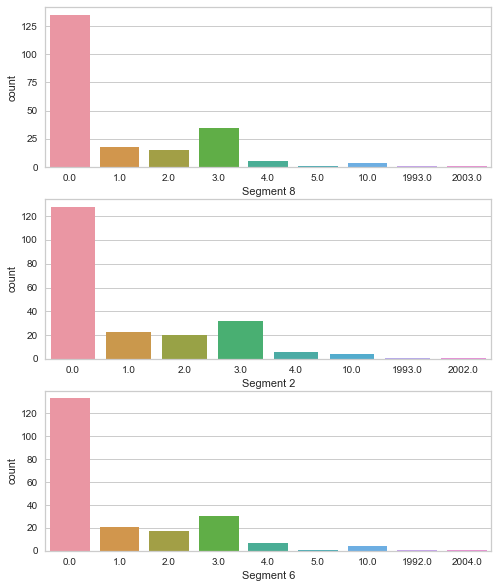

In [114]:
cluster8 = true_azdias_centers.iloc[8,:]
cluster2 = true_azdias_centers.iloc[2,:]
cluster6 = true_azdias_centers.iloc[6,:]

plt.figure(figsize=(8,10))
plt.subplot(3, 1, 1)
sns.countplot(cluster8)
plt.subplot(3, 1, 2)
sns.countplot(cluster2)
plt.subplot(3, 1, 3)
sns.countplot(cluster6)




In [314]:
#return the index of columns where the effect of attributes upon componets are >0.4
sig_li = list(np.where(pca.components_>0)[1])
azdias_d_dummy.columns.values[sig_li]

array(['ANZ_KINDER', 'ANZ_PERSONEN', 'ANZ_TITEL', ...,
       'CAMEO_INTL_2015_41', 'CAMEO_INTL_2015_43', 'HEALTH_TYP_3.0'],
      dtype=object)

In [315]:
cluster8=cluster8.sort_values(ascending=False)
cluster8_df = cluster8[cluster8[cluster8.notnull()]>0]


In [316]:
cluster8_df[cluster8_df.index.str.contains('CAMEO')]

CAMEO_DEUG_2015_4     1.0
CAMEO_INTL_2015_24    1.0
Name: Segment 8, dtype: float64

In [317]:
c8_D19 = cluster8_df[cluster8_df.index.str.contains('D19')]
c8_D19 = pd.DataFrame(c8_D19).reset_index()

In [335]:
D_19 = pd.merge(c8_D19, c2_D19, on='index', how='outer')
D_19 = pd.merge(D_19, c6_D19, on='index', how='outer')

In [334]:
KBA = pd.merge(c8_KBA, c2_KBA, on='index', how='outer')
KBA = pd.merge(KBA, c6_KBA, on='index', how='outer')

In [320]:
c8_KBA = cluster8_df[cluster8_df.index.str.contains('KBA')]
c8_KBA = pd.DataFrame(c8_KBA).reset_index()

In [321]:
c8 = cluster8_df[cluster8_df.index & azdias_d_dummy.columns.values[sig_li]]
c8 = pd.DataFrame(c8).reset_index()

In [322]:
cluster2=cluster2.sort_values(ascending=False)
cluster2_df = cluster2[cluster2[cluster2.notnull()]>0]
cluster2_df

EINGEZOGENAM_HH_JAHR       2002.0
MIN_GEBAEUDEJAHR           1993.0
D19_TELKO_ONLINE_DATUM       10.0
D19_VERSI_ONLINE_DATUM       10.0
D19_VERSI_OFFLINE_DATUM      10.0
                            ...  
D19_BEKLEIDUNG_REST           1.0
OST_WEST_KZ_W                 1.0
D19_BILDUNG                   1.0
D19_DROGERIEARTIKEL           1.0
VHA                           1.0
Name: Segment 2, Length: 87, dtype: float64

In [323]:
cluster2_df[cluster2_df.index.str.contains('CAMEO')]

CAMEO_INTL_2015_14    1.0
CAMEO_DEUG_2015_2     1.0
Name: Segment 2, dtype: float64

In [324]:
c2_D19 = cluster2_df[cluster2_df.index.str.contains('D19')]
c2_D19 = pd.DataFrame(c2_D19).reset_index()

In [325]:
c2_KBA = cluster2_df[cluster2_df.index.str.contains('KBA')]
c2_KBA = pd.DataFrame(c2_KBA).reset_index()

In [326]:
c2 = cluster2_df[cluster2_df.index & azdias_d_dummy.columns.values[sig_li]]
c2 = pd.DataFrame(c2).reset_index()

In [327]:
cluster6=cluster6.sort_values(ascending=False)
cluster6_df = cluster6[cluster6[cluster6.notnull()]>0]
cluster6_df

EINGEZOGENAM_HH_JAHR        2004.0
MIN_GEBAEUDEJAHR            1992.0
D19_VERSI_ONLINE_DATUM        10.0
D19_BANKEN_OFFLINE_DATUM      10.0
D19_VERSI_OFFLINE_DATUM       10.0
                             ...  
OST_WEST_KZ_W                  1.0
VERS_TYP_2.0                   1.0
D19_SAMMELARTIKEL              1.0
KBA05_ANTG2                    1.0
NATIONALITAET_KZ_1.0           1.0
Name: Segment 6, Length: 82, dtype: float64

In [328]:
cluster6_df[cluster6_df.index.str.contains('CAMEO')]

CAMEO_INTL_2015_55    1.0
CAMEO_DEUG_2015_8     1.0
CAMEO_DEU_2015_8D     1.0
Name: Segment 6, dtype: float64

In [336]:
c6_D19 = cluster6_df[cluster6_df.index.str.contains('D19')]
c6_D19 = pd.DataFrame(c6_D19).reset_index()

In [337]:
c6_KBA = cluster6_df[cluster6_df.index.str.contains('KBA')]
c6_KBA = pd.DataFrame(c6_KBA).reset_index()

In [331]:
c6 = cluster6_df[cluster6_df.index & azdias_d_dummy.columns.values[sig_li]]
c6 = pd.DataFrame(c6).reset_index()

In [332]:
c_pos_neg = pd.merge(c8, c2, on='index', how='outer')
c_pos_neg = pd.merge(c_pos_neg, c6, on='index', how='outer')
c_pos_neg

,index,Segment 8,Segment 2,Segment 6
0,EINGEZOGENAM_HH_JAHR,2003.0,2002.0,2004.0
1,MIN_GEBAEUDEJAHR,1993.0,1993.0,1992.0
2,D19_VERSI_ONLINE_DATUM,10.0,10.0,10.0
3,D19_BANKEN_OFFLINE_DATUM,10.0,10.0,10.0
4,D19_TELKO_ONLINE_DATUM,10.0,10.0,10.0
...,...,...,...,...
89,VHA,NaN,1.0,NaN
90,KBA05_HERSTTEMP_3.0,NaN,NaN,1.0
91,CAMEO_INTL_2015_55,NaN,NaN,1.0
92,CAMEO_DEUG_2015_8,NaN,NaN,1.0


In [333]:
c_pos_neg.to_csv('customer_clusters.csv', index=False)

#### Clusters the most likely as core customer base:

Cluster 2
* wealthy households:older families and mature Couples 
* upper-middle class
* high purchasing power
* high level of financial focus on the own house
* multibuyer of luxury clothing, shoes, leisure products, education products, guidebooks and drugstore products in the past 0-12 months
* distance to next urban centre at 30-40 km
* green avantgarde consumers: the environmental sustainability is the dominating movement of these consumers

Cluster 8

* prosperous households:older families and mature couples
* consumption-oriented middle class
* average purchasing power
* average level of financial focus on the own house
* multibuyer of drugstore products in the past 0-12 months
* distance to next urban centre at 40-50 km
* non-green avantgarde consumers

#### clusters the most unlikely as core customer base:

Cluster 6

* poorer households:elders in retirement,town seniors 
* working class
* low level of financial focus on the own house
* low share of car owners in between 31 and 45 years of age
* low share of roadmobiles,cars with 2000ccm to 2499ccm, cars with more than 2500ccm
* distance to next urban centre at 30-40 km
* non-green avantgarde consumers
* stayed lower/average level regarding development of the most common car manufacturers in the neighbourhood

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

#### 1. Load training and testing data set

In [274]:
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

#### 2. Conduct data cleaning processing 

In [275]:
mailout_train_drop_na, mailout_train_dummy = clean_data(mailout_train, df_common_dict = df_common_dict, col_list = col_list, drop_unique_cols = drop_unique_cols, str_list = str_list, drop_corr_list = drop_corr_list, c_list=c_list)

[========================================================================] 100%


Identify missing or unknown data values by decoding and convert them to NaNs.
Drop rows with Nan values.
66.22% of data is reserved after removing null values.
Clean string columns dataframe.


In [276]:
mailout_test_impute_na, mailout_test_dummy = clean_data_test(mailout_test, df_common_dict = df_common_dict, col_list = col_list, drop_unique_cols = drop_unique_cols, str_list = str_list, drop_corr_list = drop_corr_list, c_list=c_list)

[========================================================================] 100%


Identify missing or unknown data values by decoding and convert them to NaNs.


[========================================================================] 100%


Impute Nan values with the most frequent values by row.
Clean string columns dataframe.


In [277]:
print('mailout_train_dummy shape:{}'.format(mailout_train_dummy.shape))
print('mailout_test_dummy shape:{}'.format(mailout_test_dummy.shape))

mailout_train_dummy shape:(28449, 214)
mailout_test_dummy shape:(42833, 214)


#### 3. Feature Scaling

In [278]:
mailout_train_Scaler = sc.fit_transform(mailout_train_dummy)
mailout_test_Scaler = sc.fit_transform(mailout_test_dummy)

In [279]:
print(mailout_train_Scaler.shape)
print(mailout_test_Scaler.shape)

(28449, 214)
(42833, 214)


In [280]:
train_rows = list(mailout_train_drop_na.index)

#### 4. Feature transformation:dimenstion reduction

In [281]:
#Feature Reduction
# Instantiate
pca = PCA(n_components=152)

# Fit PCA and apply upon train and test
pca.fit(mailout_train_Scaler)

pca_train_scores = pca.transform(mailout_train_Scaler)
pca_test_scores = pca.transform(mailout_test_Scaler)


#### 5. Understand the data: preliminary cluster Analysis 

In [302]:
# refoerm PCA with optimised number of clusters
clusterer = KMeans(n_clusters=12, random_state=42).fit(pca_train_scores)
pca_train_preds = clusterer.predict(pca_train_scores)
centers = clusterer.cluster_centers_
center_pred = clusterer.predict(centers)


Text(0.5, 1.0, 'Customer Training Dataset')

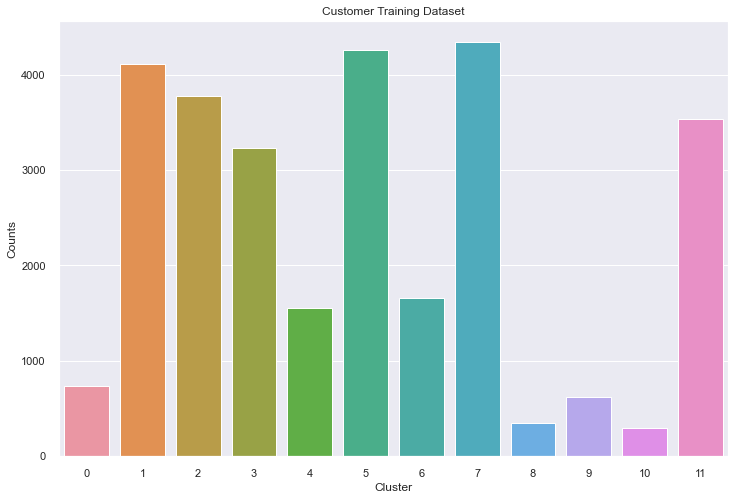

In [345]:
plt.figure(figsize=(12,8))
sns.countplot(pca_train_preds)
plt.xlabel('Cluster')
plt.ylabel('Counts')
plt.title('Customer Training Dataset')



Text(0, 0.5, 'Second Principal Component')

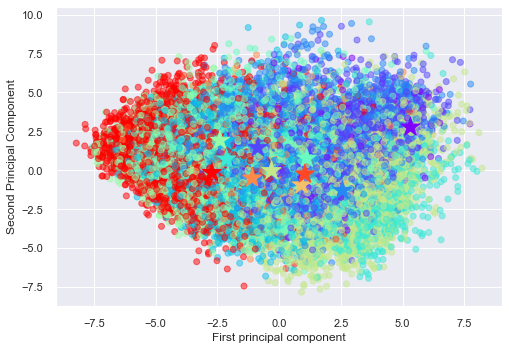

In [346]:
# Scatter Plot of component 1 and component 2

plt.scatter(pca_train_scores[:,0], 
            pca_train_scores[:,1],
            alpha=0.5,
            c=pca_train_preds,cmap='rainbow')


plt.scatter(clusterer.cluster_centers_[:,0],
           clusterer.cluster_centers_[:,1],
           s=395,
           marker='*',
           c=center_pred,
           cmap='rainbow',
           label='Centroids')


plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')



In [349]:
import plotly.express as px

fig = px.scatter_3d(
    x= pca_train_scores[:700,0],
    y= pca_train_scores[:700,1],
    z= pca_train_scores[:700,2],
    color = pca_train_preds[:700].astype(str),
    symbol= mailout_train.loc[train_rows,'RESPONSE'][:700],
    color_discrete_sequence = px.colors.qualitative.Pastel,
    title='3D Principle Components Scatter Plot',
    opacity=0.7
    )

fig.show()

#### 6.Split training dataset into training and testing dataset: apply GridSearchCV to find out optimal model and best estimators

In [351]:
#build supervised machine learning model using pca_train_scores dataset
#split into train test sets
x_train1,x_test1,y_train1,y_test1 = train_test_split(pca_train_scores, mailout_train.loc[train_rows,'RESPONSE'], test_size = 0.2, random_state = 42)

In [352]:
import time
from sklearn.metrics import roc_curve
# fit different classifiers on training dataset
# find the best performing classifier algorithm
def fit_classifier(clf, param_grid, x=x_train1, y=y_train1, xtest=x_test1, ytest=y_test1):
    """
    Fits a classifier to its training data using GridSearchCV and calculates ROC AUC score
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=0)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(x, y)
    end = time.time()
    time_taken = round(end-start,2)
    pred_prob = grid.predict_proba(xtest)
    #roc curve for the model
    fpr, tpr, thresh = roc_curve(ytest, pred_prob[:,1], pos_label=1)

    print(clf.__class__.__name__)
    print("Time taken : {} secs".format(time_taken))
    print("Best score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    return grid.best_score_, grid.best_estimator_, time_taken, fpr, tpr

In [359]:
lor = LogisticRegression(random_state=42) # LogisticRegression
rfc = RandomForestClassifier(random_state=42) # RandomForestClassifier
abc = AdaBoostClassifier(random_state=42) # AdaBoostClassifier
#gbc = GradientBoostingClassifier(random_state=42) # GradientBoostingClassifier
#lsvc = LinearSVC(random_state=42) #LinearSupportVectorClassifier
#lgbm = lgb.LGBMRegressor(random_state=42)
xgb = XGBClassifier(random_state=42)
gnb = GaussianNB() 
bnb = BernoulliNB()
lgbmc = lgb.LGBMClassifier(random_state=42)


In [360]:
# Find best classification algorithm
clf_names = []
clf_scores = []
clf_best_ests = []
clf_time_taken = []
clf_dict = {}
clf_fpr = []
clf_tpr = []

for clf in [xgb,lgbmc,gnb,bnb,lor, rfc, abc]:
    best_score, best_est, time_taken,fpr, tpr = fit_classifier(clf, {})
    clf_names.append(clf.__class__.__name__)
    clf_scores.append(best_score)
    clf_best_ests.append(best_est)
    clf_time_taken.append(time_taken)
    clf_fpr.append(fpr)
    clf_tpr.append(tpr)
   

Training XGBClassifier :
[13:32:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:32:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:33:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:33:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metri

In [361]:
clf_dict['best_score'] = clf_scores
clf_dict['time_taken'] = clf_time_taken
clf_dict['best_est'] = clf_best_ests
clf_dict['best_fpr'] = clf_fpr
clf_dict['best_tpr']    = clf_tpr

clf_df = pd.DataFrame(clf_dict, index=clf_names)
clf_df

,best_score,time_taken,best_est,best_fpr,best_tpr
XGBClassifier,0.501898,164.80,"XGBClassifier(base_score=0.5, booster='gbtree'...","[0.0, 0.00017774617845716317, 0.01173124777817...","[0.0, 0.0, 0.0, 0.015625, 0.015625, 0.03125, 0..."
LGBMClassifier,0.516041,12.76,LGBMClassifier(random_state=42),"[0.0, 0.00017774617845716317, 0.00266619267685...","[0.0, 0.0, 0.0, 0.015625, 0.015625, 0.03125, 0..."
GaussianNB,0.521069,0.53,GaussianNB(),"[0.0, 0.002310700319943121, 0.0252399573409171...","[0.0, 0.0, 0.0, 0.015625, 0.015625, 0.03125, 0..."
BernoulliNB,0.518585,0.56,BernoulliNB(),"[0.0, 0.00017774617845716317, 0.02452897262708...","[0.0, 0.0, 0.0, 0.015625, 0.015625, 0.03125, 0..."
LogisticRegression,0.563481,2.53,LogisticRegression(random_state=42),"[0.0, 0.00017774617845716317, 0.03217205830074...","[0.0, 0.0, 0.0, 0.015625, 0.015625, 0.03125, 0..."
RandomForestClassifier,0.509299,273.96,"(DecisionTreeClassifier(max_features='auto', r...","[0.0, 0.00017774617845716317, 0.00035549235691...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
AdaBoostClassifier,0.542220,121.84,"(DecisionTreeClassifier(max_depth=1, random_st...","[0.0, 0.00017774617845716317, 0.00391041592605...","[0.0, 0.0, 0.0, 0.015625, 0.015625, 0.03125, 0..."


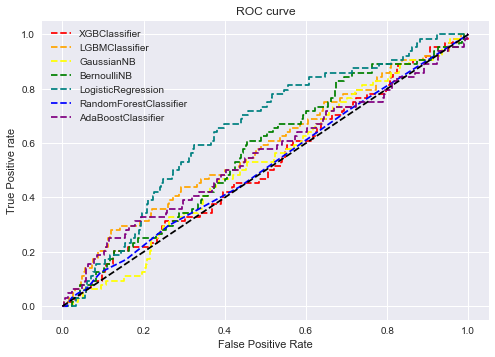

In [363]:

# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')


# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test1))]
p_fpr, p_tpr, _ = roc_curve(y_test1, random_probs, pos_label=1)

# plot roc curves
plt.plot(clf_df.loc['XGBClassifier','best_fpr'], clf_df.loc['XGBClassifier','best_tpr'], linestyle='--',color='red', label='XGBClassifier')
plt.plot(clf_df.loc['LGBMClassifier','best_fpr'], clf_df.loc['LGBMClassifier','best_tpr'], linestyle='--',color='orange', label='LGBMClassifier')
plt.plot(clf_df.loc['GaussianNB','best_fpr'], clf_df.loc['GaussianNB','best_tpr'], linestyle='--',color='yellow', label='GaussianNB')
plt.plot(clf_df.loc['BernoulliNB','best_fpr'], clf_df.loc['BernoulliNB','best_tpr'], linestyle='--',color='green', label='BernoulliNB')
plt.plot(clf_df.loc['LogisticRegression','best_fpr'], clf_df.loc['LogisticRegression','best_tpr'], linestyle='--',color='teal', label='LogisticRegression')
plt.plot(clf_df.loc['RandomForestClassifier','best_fpr'], clf_df.loc['RandomForestClassifier','best_tpr'], linestyle='--',color='blue', label='RandomForestClassifier')
plt.plot(clf_df.loc['AdaBoostClassifier','best_fpr'], clf_df.loc['AdaBoostClassifier','best_tpr'], linestyle='--',color='purple', label='AdaBoostClassifier')


plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

#### 7. Apply the optimal model on traing and testing dataset with evaluation score

In [293]:
clf_df.loc['LogisticRegression', 'best_est']

LogisticRegression(random_state=42)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [294]:
#fit and evaluate the model upon test data
model = LogisticRegression(random_state=42)
model.fit(x_train1,y_train1)
yhat=model.predict(x_test1)
#evaluate predictions
acc = accuracy_score(y_test1, yhat)
print('Accuracy:%.3f' % acc)
roc_score = roc_auc_score(y_test1, yhat) 
print('Roc_score:%.3f' % roc_score)

Accuracy:0.989
Roc_score:0.500


In [295]:
y_fhat = model.predict(pca_test_scores)
print(y_fhat)

[0 0 0 ... 0 0 0]


In [296]:
np.where(y_fhat !=0)

(array([], dtype=int64),)

In [297]:
y_fhat_proba = model.predict_proba(pca_test_scores)
print(y_fhat_proba )

[[0.95741643 0.04258357]
 [0.97858314 0.02141686]
 [0.99820774 0.00179226]
 ...
 [0.99060118 0.00939882]
 [0.94370668 0.05629332]
 [0.98996543 0.01003457]]


In [298]:
kaggle_df = pd.DataFrame({'LNR':mailout_test['LNR'],'RESPONSE': y_fhat_proba[:, 1] })

In [299]:
kaggle_df.head()

,LNR,RESPONSE
0,1754,0.042584
1,1770,0.021417
2,1465,0.001792
3,1470,0.002603
4,1478,0.004550


In [300]:
kaggle_df.to_csv('kaggle_submission_file_0.csv', index=False)